# Brain Tumor Classification

In [ ]:
# Dataset Splitting

## Data Loading

Testing Set Class Distribution - Class Counts:
glioma: 300
meningioma: 306
notumor: 405
pituitary: 300


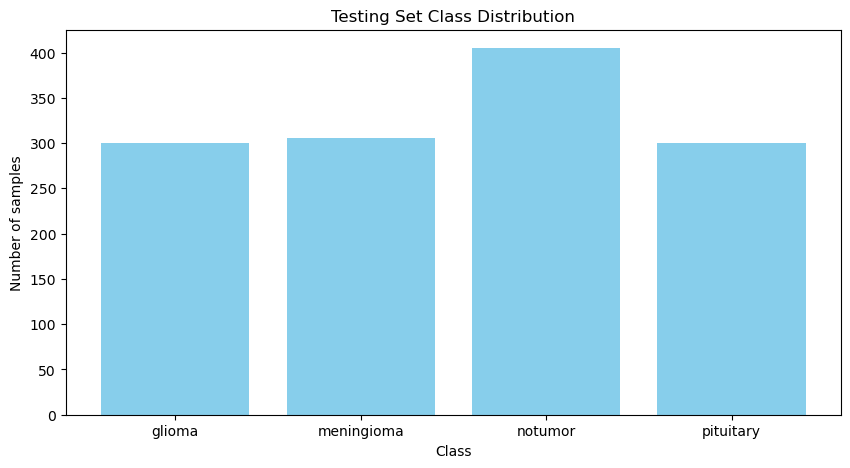

Training Set Class Distribution - Class Counts:
glioma: 1047
meningioma: 1076
notumor: 1264
pituitary: 1182


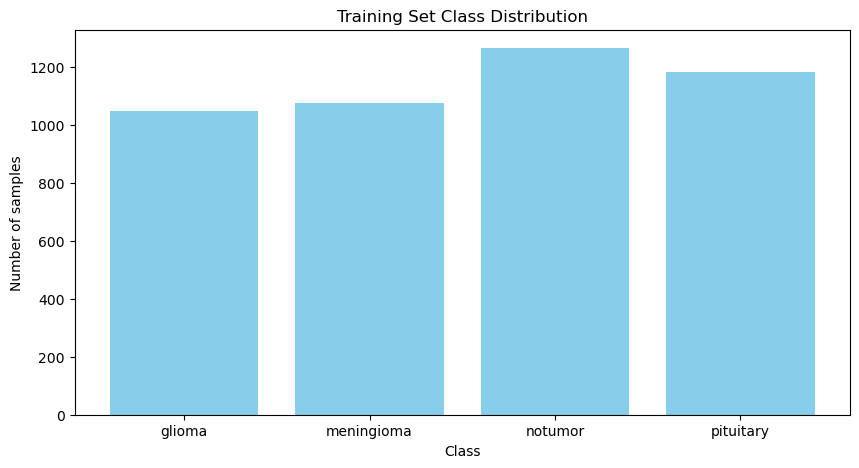

Validation Set Class Distribution - Class Counts:
glioma: 274
meningioma: 263
notumor: 331
pituitary: 275


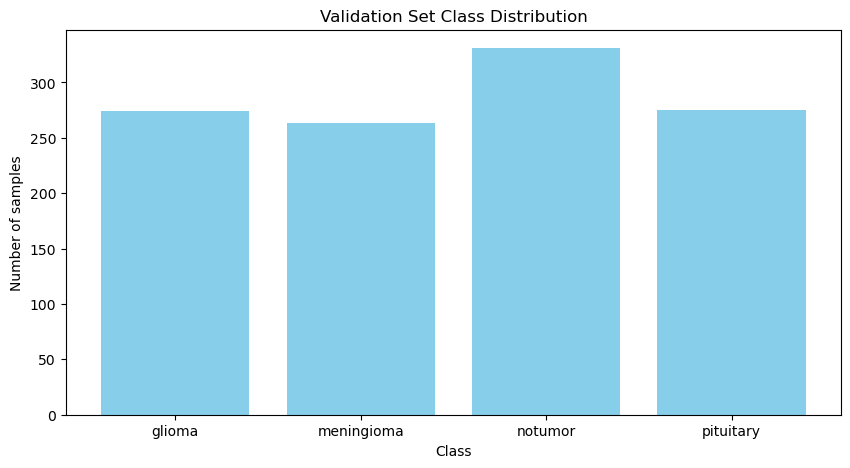

In [2]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

BASE_DIR = 'dataset2'
TRAIN_VAL_SPLIT = 0.8

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Testing'), transform=transform)
validation_Dataset

# Splitting the dataset into training and validation
train_size = int(TRAIN_VAL_SPLIT * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)




# # Function to plot and print class distribution
# def plot_distribution(dataset, indices=None, title='Dataset Class Distribution'):
#     class_counts = {class_label: 0 for class_label in dataset.classes}
#     if indices is None:
#         # If no indices provided, use all samples from the dataset
#         for _, label in dataset.samples:
#             class_label = dataset.classes[label]
#             class_counts[class_label] += 1
#     else:
#         # Use only specified indices (for subsets from random_split)
#         for idx in indices:
#             _, label = dataset.samples[idx]
#             class_label = dataset.classes[label]
#             class_counts[class_label] += 1

#     # Print class counts
#     print(f"{title} - Class Counts:")
#     for class_label, count in class_counts.items():
#         print(f"{class_label}: {count}")

#     # Plotting
#     plt.figure(figsize=(10, 5))
#     plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
#     plt.xlabel('Class')
#     plt.ylabel('Number of samples')
#     plt.title(title)
#     plt.show()

# # Plotting and printing class distributions
# plot_distribution(test_dataset, title='Testing Set Class Distribution')
# plot_distribution(train_dataset, train_data.indices, 'Training Set Class Distribution')
# plot_distribution(train_dataset, val_data.indices, 'Validation Set Class Distribution')


## CNN Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 4)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
from torch import nn
import matplotlib.pyplot as plt

def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        print("CUDA")
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("MPS")
        device = torch.device("mps")
    else:
        print("CPU")
        device = torch.device("cpu")

    model = model.to(device)
    
    # Lists to track the losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        average_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        average_val_loss = running_val_loss / len(valid_loader)
        val_accuracy = 100 * correct_val / total_val
        valid_losses.append(average_val_loss)
        valid_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies


def save_model(model, directory="models"):
    os.makedirs(directory, exist_ok=True)
    
    highest_num = 0
    for filename in os.listdir(directory):
        if filename.startswith("model_") and filename.endswith(".pth"):
            num = int(filename.split('_')[1].split('.')[0])
            if num > highest_num:
                highest_num = num
    
    model_filename = f"model_{highest_num + 1}.pth"
    model_path = os.path.join(directory, model_filename)
    
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_filename} in directory '{directory}'.")


def load_model(model, model_number = None, directory="models"):
    if model_number is None:
        model_number = 0
        for filename in os.listdir(directory):
            if filename.startswith("model_") and filename.endswith(".pth"):
                num = int(filename.split('_')[1].split('.')[0])
                if num > model_number:
                    model_number = num

    model_filename = f"model_{model_number}.pth"
    model_path = os.path.join(directory, model_filename)
    if not os.path.exists(model_path):
        print(f"No model found with the name {model_filename} in directory '{directory}'.")
        return None
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_filename}.")
    return model


def test_model(model, test_loader):
    model.eval()  
    criterion = nn.CrossEntropyLoss()  

    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model = model.to(device)

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


def plot_metric(train_metric, valid_metric, metric_name, save_path='figures/img.png'):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(valid_metric, label=f'Validation Loss {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.savefig(save_path)

### Training

In [6]:
model = CNN()  # Assuming CNN is your model class
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, validation_loader, num_epochs=4)

NameError: name 'CNN' is not defined

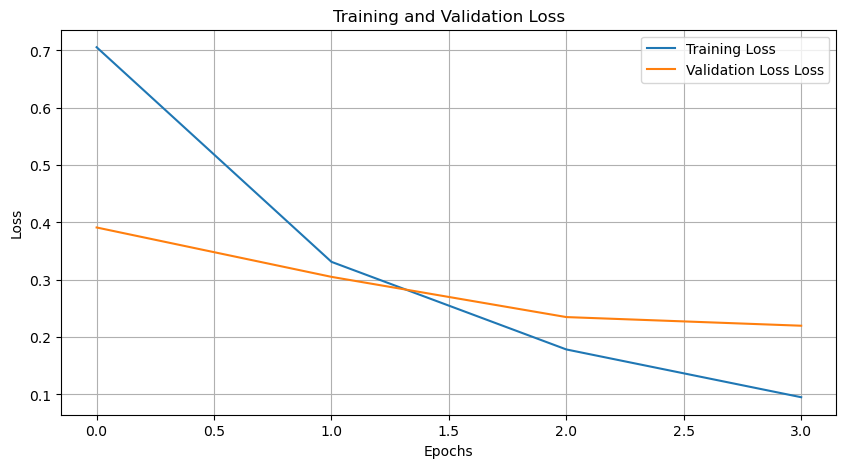

<Figure size 640x480 with 0 Axes>

In [15]:
# Now plot the losses
plot_metric(train_losses, valid_losses, 'Loss')

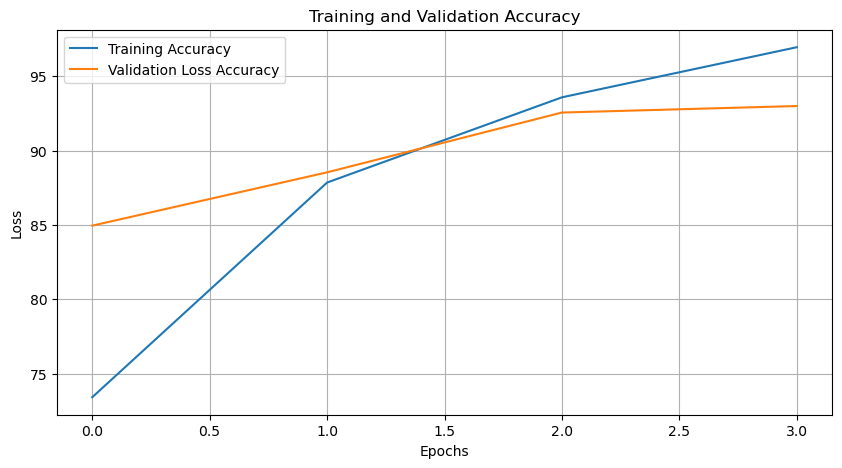

<Figure size 640x480 with 0 Axes>

In [16]:
plot_metric(train_accuracies, valid_accuracies, 'Accuracy')

### Testing Model and Test Dataset

In [17]:
test_model(model, test_loader)
save_model(model)

Test Loss: 0.1999, Test Accuracy: 92.75%
Model saved as model_5.pth in directory 'models'.


In [18]:
### Loads and tests latest model
testing_model = CNN()
testing_model = load_model(testing_model)   # Specify model number if you want to load an older model: load_model(testing_model, 1)
test_model(testing_model, test_loader)

Model loaded from model_5.pth.
Test Loss: 0.1999, Test Accuracy: 92.75%


In [19]:
!pip3 install torchviz

Defaulting to user installation because normal site-packages is not writeable


In [20]:
from torchviz import make_dot

def visualize_model(model, input_size=(3, 150, 150)):
    # Create a dummy input tensor with the correct size
    dummy_input = torch.randn(1, *input_size, requires_grad=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dummy_input = dummy_input.to(device)
    model = model.to(device)
    
    # Forward pass through the model
    output = model(dummy_input)
    
    # Create dot graph of the model
    dot = make_dot(output, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))
    return dot

# Example usage:
dot = visualize_model(model)
dot.render('model_visualization', format='png', cleanup=True)  # This saves the diagram as a PNG

'model_visualization.png'

# Interpretability

## Saliency Maps

In [ ]:
import torch
from torch.autograd import Variable

def generate_saliency_maps(model, data_loader, device):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    # We need to make the images require_grad to compute gradients with respect to images
    images.requires_grad_()

    outputs = model(images)
    # Get the index of the max log-probability
    _, predicted = torch.max(outputs.data, 1)
    
    outputs[:, predicted].backward(torch.ones_like(outputs[:, predicted]))

    # Get gradient for the input image
    gradients = images.grad.data.abs()

    # Get the maximum values across the color channels
    saliency, _ = torch.max(gradients, dim=1)
    
    return images, saliency

# Usage example:


In [ ]:
images, saliency_maps = generate_saliency_maps(model, train_loader, device)
Plotting the first image and its saliency map:
plt.imshow(images[0].cpu().detach().permute(1, 2, 0))
plt.imshow(saliency_maps[0].cpu(), cmap='hot', alpha=0.5)
plt.show()

## GradCam

In [ ]:
import torch.nn.functional as F
from torch.autograd import Function

class SaveFeatures():
    """ Extractor for the features used in Grad-CAM"""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.clone().detach()
    def close(self):
        self.hook.remove()

def grad_cam(model, data_loader, device, target_layer):
    model.eval()
    fmap_block = SaveFeatures(list(model.children())[target_layer])  # Change this index to your last conv layer index
    grad_block = SaveFeatures(list(model.children())[target_layer])  # Same as above

    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    output[:, output.argmax(dim=1)].backward()  # We use the class with the highest output

    grads_val = grad_block.features[0].cpu().data.numpy()
    fmap = fmap_block.features[0].cpu().data.numpy()

    weights = np.mean(grads_val, axis=(1, 2))  # Global Average Pooling on gradients

    cam = np.zeros(fmap.shape[1:], dtype=np.float32)  # Initialize CAM

    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = cam - np.min(cam)  # Normalize between 0-1
    cam = cam / np.max(cam)

    fmap_block.close()
    grad_block.close()
    
    return images, cam

# Usage example:
# images, cam_result = grad_cam(model, train_loader, device, target_layer=-1)  # -1 for the last layer
# plt.imshow(images[0].cpu().detach().permute(1, 2, 0))
# plt.imshow(cam_result, cmap='magma', alpha=0.5)  # Overlay the CAM result
# plt.show()=

# ViT

# Data Loading (again)

In [19]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

BASE_DIR = 'dataset2'
TRAIN_VAL_SPLIT = 0.8

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Testing'), transform=transform)

# Splitting the dataset into training and validation
train_size = int(TRAIN_VAL_SPLIT * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [20]:
!pip3 install timm

Defaulting to user installation because normal site-packages is not writeable


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

# Define the Vision Transformer Model
class ViTModel(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super(ViTModel, self).__init__()
        # Load a pre-trained Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)

    def forward(self, x):
        x = self.vit(x)
        return x

# Adjust the transformations for ViT input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Assuming the dataset setup remains the same with paths 'Training' and 'Testing'
BASE_DIR = 'dataset2'
train_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Training'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(BASE_DIR, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Example of using the train_model function remains mostly the same
model = ViTModel(num_classes=4)  # Ensure the num_classes matches your dataset
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, validation_loader, num_epochs=10, learning_rate=5e-4)

CUDA
Epoch 1, Train Loss: 1.1473, Train Acc: 52.82%, Val Loss: 0.8179, Val Acc: 65.22%
Epoch 2, Train Loss: 0.7120, Train Acc: 72.57%, Val Loss: 0.8323, Val Acc: 65.83%
Epoch 3, Train Loss: 0.5418, Train Acc: 79.24%, Val Loss: 0.5048, Val Acc: 79.41%
Epoch 4, Train Loss: 0.4724, Train Acc: 81.83%, Val Loss: 0.4610, Val Acc: 81.85%
Epoch 5, Train Loss: 0.4178, Train Acc: 84.56%, Val Loss: 0.4818, Val Acc: 82.68%
Epoch 6, Train Loss: 0.3805, Train Acc: 85.21%, Val Loss: 0.4307, Val Acc: 82.99%
Epoch 7, Train Loss: 0.3396, Train Acc: 87.64%, Val Loss: 0.4541, Val Acc: 82.91%
Epoch 8, Train Loss: 0.3148, Train Acc: 87.69%, Val Loss: 0.5279, Val Acc: 78.79%
Epoch 9, Train Loss: 0.3040, Train Acc: 88.52%, Val Loss: 0.4568, Val Acc: 82.99%
Epoch 10, Train Loss: 0.2820, Train Acc: 89.23%, Val Loss: 0.3868, Val Acc: 86.27%


In [22]:
def test_vit_model(model, test_loader):
    model.eval()  
    criterion = nn.CrossEntropyLoss()  

    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model = model.to(device)

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


test_vit_model(model, test_loader)
save_model(model, direcotry="vit_models")

AssertionError: Input height (150) doesn't match model (224).